In [51]:
#!/usr/bin/env python
###################################
#                                 #
# File coded by: Robert J. Koch   #
#                                 #
###################################
#
# Example 3: Refining PDFs from SrFe2As2 to investigate phase transformation
#
# This Diffpy-CMI script will carry out a structural refinement of a measured
# PDF from SrFe2As2.
#
# Import packages that we will need.
from pathlib import Path
import yaml
import pyjokes
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(str(Path().absolute().parent.parent.parent))

from diffpy.srfit.fitbase import FitResults, Profile
from diffpy.srfit.pdf import PDFParser
from diffpy.structure.parsers import getParser
from scipy.optimize import least_squares
from cmi_demos.utils.helpers import makerecipe
from cmi_demos.utils.helpers import plotresults
print(pyjokes.get_joke())

What does pyjokes have in common with Adobe Flash? It gets updated all the time, but never gets any better.


In [52]:
############### Config ##############################
# Give a file path to where your pdf (.gr) and (.cif) files are located.
DPATH = Path("data")

# Give an identifying name for the refinement.
# Here this is just part of the basename we will use,
# as we will consider different structure models and
# different temperatures.
FIT_ID_BASE = "Fit_SrFe2As2_"

# Specify a string pattern for the PDF and cif files.
# Again, this is just part of the filename we will use,
# as we will consider different structure models and
# different temperatures.
# Each of our *.cif files and *.gr files we want to use will need
# to match this pattern.
GR_NAME_BASE = "SrFe2As2_"
CIF_NAME_BASE = GR_NAME_BASE

# This will allow us to skip things we've already done
SKIP_DONE = False

REPLOT_DONE = True

######## Experimental PDF Config ######################
# Specify the min, max, and step r-values of the PDF (that we want to fit over)
# also, specify the Q_max and Q_min values used to reduce the PDF.
PDF_RMIN = 1.5
PDF_RMAX = 50
PDF_RSTEP = 0.01
QMAX = 25
QMIN = 0.1

########PDF initialize refinable variables #############
# In this case, initial values for the lattice
# parameters and ADPs will be taken directly from the .cif
# structures, so we don't need to specify them here.
SCALE_I = 0.4
DELTA1_I = 1.6

# Instrumental will be fixed based on values obtained from a
# separate calibration step. These are hard-coded here.
QDAMP_I = 0.0349
QBROAD_I = 0.0176

print(pyjokes.get_joke())

How many programmers does it take to change a lightbulb? None, that's a hardware problem.


In [47]:
# Make some folders to store our output files.
resdir = "res"
fitdir = "fit"
figdir = "fig"

folders = [resdir, fitdir, figdir]

# Let's define our working directory.
base_dir = Path()

# We're going to want to write our fit results in some convenient format,
# as we'll generate a lot of data. We will use a "yaml" type file for this.
# Here we define a name for it.
yaml_file = base_dir / (FIT_ID_BASE + "refined_params.yml")

print(pyjokes.get_joke())

Two threads walk into a bar. The barkeeper looks up and yells, 'Hey, I want don't any conditions race like time last!'


In [48]:
# This is a bit different than what we've done before.
# We are going to look at a set of temperatures, so we want
# to find all the relevant data files in the "DPATH" folder
# we identified earlier which match a certain pattern.

# For every file we find, we will link it up with the data path
data_files = list(DPATH.glob(f"*{GR_NAME_BASE}*.gr"))


# We now want to grab the temperature at which each file was measured.
# We again use list comprehension, and we re-use the variable "temp"
# This specific procedure depends on how the file is named.
# In our case, we carefully named each file as:
# "composition_TTTK.gr" where TTT is the temperature in Kelvin.

# First we strip off the directory information for every file in "data_files"
# This gives us a list of just full file names, without directories.
temps = [f.stem for f in data_files]

# Next we split every base filename into a list, delimited by "_"
# We keep the second entry from this list, because we know it has the
# temperature in the form TTTK.
temps = [t.split('_')[1] for t in temps]

# We want the temperature as an integer, so we need to drop the "K"
# from each string and cast the values as integers using "int()"
# Strings can be slides like arrays, so "[:-1]" means "take all the
# values except the last one."
temps = [int(t[:-1]) for t in temps]

# This will sort the data files and temperatures in descending order
# based on the temperature values.
temps, data_files = zip(*sorted(zip(temps, data_files), reverse=True))
print(pyjokes.get_joke())

Ubuntu users are apt to get this joke.


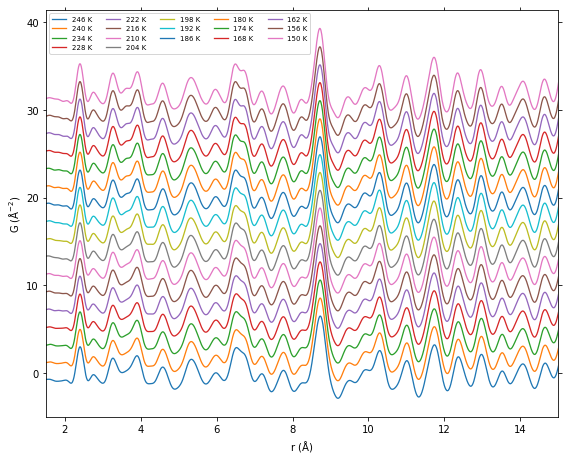

Microsoft hold a bi-monthly internal "productive week" where they use Google instead of Bing.


In [41]:
# Let's have a look at our data files 

# We set up a plot
fig, ax1 = plt.subplots(1, 1,figsize=(8,6.5))

# We're going to want to offset each dataset. This dictates by how much
offset = 2

# Let's loop on each data file, temperature, and we'll need a loop
# integer index.
for ii, (temp, file) in enumerate(zip(temps, data_files)):
    
    # We load each file, and we skip rows without data
    data = np.loadtxt(file, skiprows=27)
    
    # We store the relevant parts of each data file in a variable.
    # we offset the G(r) data based on the loop index.
    g = data[:,1] + ii*offset
    r = data[:,0]
    
    # We put the data in the plot, and we give it the correct label.
    ax1.plot(r, g, lw=1.3, label=f"{temp} K")

# Now, outside the loop, we assign some plot labels
# x-axis label
ax1.set_xlabel("r ($\mathrm{\AA}$)")

# y-axis label
ax1.set_ylabel("G ($\mathrm{\AA}$$^{-2}$)")

# We set some reasonable r-limits for our data
ax1.set_xlim(1.5, 15.0)

# We create a plot legend
ax1.legend(fontsize=7,ncol=5)

# Let's get rid of all the useless empty space in out plot.
plt.tight_layout()

# and we show the plot
plt.show()

print(pyjokes.get_joke())

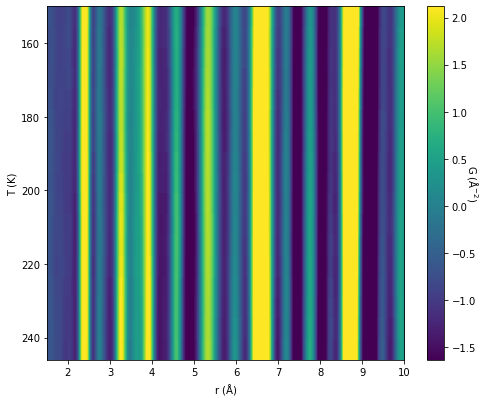

What did the Java code say to the C code? A: You've got no class.


In [50]:
# maybe this will  be better....

# We set up a plot
fig, ax1 = plt.subplots(1,1,figsize=(8,6.5))


# We don't want to plot all the data, so let's do some math and 
# figure out which part of the r array we need
r_step = 0.01

# You could change this
r_start_index = 1.5
# We can reuse variables. We also need integers for arrays indixing
r_start_index = int(r_start_index/r_step)

# You could also change this
r_stop_index = 10
# We can reuse variables. We also need integers for arrays indixing
r_stop_index = int(r_stop_index/r_step)

# Create an empty list to store the data.
d_list = []

# Let's loop on each data file, temperature, and we'll need a loop
# integer index.
for ii, (temp, file) in enumerate(zip(temps, data_files)):
    # We load each file, and we skip rows without data
    data = np.loadtxt(file, skiprows=27)
    
    # We store the relevant parts of each data file in a variable.
    # This time we don't need any offset.
    # We only use the relevant parts of the data array
    r = data[r_start_index:r_stop_index,0]
    g = data[r_start_index:r_stop_index,1]
    
    # Add the array of G(r) values to the end of our list to store the data.
    d_list.append(g)

# Convert our list to an array.
d_list = np.array(d_list)

# let's get some resonalbe values to plot over.
# These will get the G(r) value which defines the 10% and 90% percentiles.
vmin = np.percentile(d_list,10)
vmax = np.percentile(d_list,90)

# Outside the loop, we add the data to our plot.
im = ax1.imshow(d_list,
                # We want an aspect ratio dictated by our plot size.
                aspect="auto",
                # We tell the plot what our plot ranges are
                # [left,right,bottom,top]
                extent=[r[0],r[-1],temps[0],temps[-1]],
                # We don't need no stinking interpolation!
                # The data are the data!
                interpolation="none",
                # Tell what color ranges to plot over
                vmin=vmin,
                vmax=vmax)

# We assign some plot labels

# x-axis label
ax1.set_xlabel("r ($\mathrm{\AA}$)")

# y-axis label
ax1.set_ylabel("T (K)")

# Let's add a colorbar!
cbar = fig.colorbar(im)

# Now, Label that colorbar!
cbar.set_label("G ($\mathrm{\AA}$$^{-2}$)", rotation=270)
plt.show()

print(pyjokes.get_joke())

In [ ]:
# We want to test two structure models, so we should find both the cif files.
# Similar to how we found the data files, we use list comprehension

# For every file we find, we will link it up with the data path
cif_files = list(DPATH.glob(f"*{CIF_NAME_BASE}*.cif"))

# We initialize and empty dictionary, if it doesn't exist,where we will save all
# the details of the refined parameters.
if yaml_file.exists():
    print(f"\n{yaml_file.name} exists, loading!\n")
    with open(yaml_file, 'r') as infile:
        refined_dict = yaml.safe_load(infile)
else:
    # If it exists, we load it!
    # We don't want to duplicate our work!
    print(f"\n{yaml_file.name} does not exist, creating!\n")
    refined_dict = dict()


print(pyjokes.get_joke())    

In [ ]:
# We want to do a separate temperature series on each of the structures,
# so we will use a loop on all the cif files we found.
for cif in cif_files:



    # Let's get the space group, so we can refer to it later.
    p_cif = getParser('cif')
    p_cif.parseFile(str(cif))
    space_group = p_cif.spacegroup.short_name

    # Backslashes are bad form, so let's remove them...
    structure_string = space_group.replace("/", "_on_")

    # Lets check if we already ran this fit...so we dont duplicate work
    if structure_string not in refined_dict:
        print(f"\n{structure_string} IS NOT in dictionary!\n")
        # Nest a dictionary inside "refined_dict" with a key defined by "stru_type"
        refined_dict[structure_string] = dict()

        # This is just for ease of coding/readability
        sg_dict = refined_dict[structure_string]
        done = False
    elif structure_string in refined_dict:
        print(f"\n{structure_string} IS IN dictionary!\n")
        sg_dict = refined_dict[structure_string]
        done = True

    # Where will we work? here!
    work_dir = base_dir / structure_string
    
    # Make our folders!
    for folder in folders:
        new_folder = work_dir / folder
        if not new_folder.exists():
            new_folder.mkdir(parents=True)


    # Make a recipe based on this cif file, and the first data file in
    # "data_files"
    # We can pass in any data file at this point, this is only to initialize
    # the recipe, and we will replace this data before refining.
    recipe = makerecipe(cif, data_files[0])

    # Let's set our structure range
    recipe.crystal.profile.setCalculationRange(xmin=PDF_RMIN, xmax=PDF_RMAX, dx=PDF_RSTEP)



    # Initialize the instrument parameters, Q_damp and Q_broad, and
    # assign Q_max and Q_min.
    recipe.crystal.G1.qdamp.value = QDAMP_I
    recipe.crystal.G1.qbroad.value = QBROAD_I
    recipe.crystal.G1.setQmax(QMAX)
    recipe.crystal.G1.setQmin(QMIN)

    # Add, initialize, and tag the scale variable.
    recipe.addVar(recipe.crystal.s1, SCALE_I, tag="scale")

    # Use the srfit function constrainAsSpaceGroup to constrain
    # the lattice and ADP parameters according to the space group setting,
    # in this case, contained in the function argument "sg"
    #
    from diffpy.srfit.structure import constrainAsSpaceGroup

    spacegroupparams = constrainAsSpaceGroup(recipe.crystal.G1.phase,
                                             space_group)

    for par in spacegroupparams.latpars:
        recipe.addVar(par, fixed=False, tag="lat")

    for par in spacegroupparams.adppars:
        recipe.addVar(par, fixed=False, tag="adp")

    # Note: here we also can refine atomic coordinates.
    # In our previous examples, all the atoms were on symmetry
    # operators, so their positions could not be refined.
    for par in spacegroupparams.xyzpars:
        recipe.addVar(par, fixed=False, tag="xyz")

    # Add delta, but not instrumental parameters to Fit Recipe.
    recipe.addVar(recipe.crystal.G1.delta2,
                  name="Delta2",
                  value=DELTA1_I,
                  tag="d2")

    # Tell the Fit Recipe we want to write the minimum amount of
    # information to the terminal during fitting.
    recipe.fithooks[0].verbose = 0


    # As we are doing a temperature series through a phase transition, we want to fit many
    # different data sets, each at a different temperature.
    # for this we will loop over both "temps" and "data_files"
    for file, temp in zip(data_files, temps):
        print(f"\nProcessing {file.name}!\n")

        # Lets check if we already ran this fit...so we dont duplicate work
        if temp not in sg_dict:
            print(f"\nT = {temp} K NOT IN {structure_string} dictionary, creating!\n")
            # Nest a dictionary inside the nested dictionary "refined_dict[stru_type]"
            # with a key defined by "temp"
            sg_dict[temp] = dict()
            temp_dict = sg_dict[temp]
            done = False
        elif temp in sg_dict:
            print(f"\nT = {temp} K IS IN {structure_string} dictionary!\n")
            temp_dict = sg_dict[temp]
            done = True

        # We create a unique string to identify our fit,
        # using the structure type and the temperature.
        # This will be used when we write files later.
        basename = f"{FIT_ID_BASE}{structure_string}_{str(temp)}_K"

        # Print the basename to the terminal.
        print(f"\nWorking on {basename}!\n")


        # We now want to load in the proper dataset for the given temperature.
        # We do this by creating a new profile object and loading it into the fit recipe.
        profile = Profile()
        parser = PDFParser()
        parser.parseFile(file)
        profile.loadParsedData(parser)
        recipe.crystal.setProfile(profile)
        
        # If we aren't done, we hae work to do...
        if not done:
            print(
                f"{basename} is NOT DONE with structure {structure_string} at T = {temp} K\n")

            # We are now ready to start the refinement.
            # During the optimization, fix and free parameters as you would
            # PDFgui. This leads to more stability in the refinement
            recipe.fix("all")

            refine_params = ["scale", "lat", "adp", "d2", "all"]

            for params in refine_params:
                recipe.free(params)
                print(f"\n****\nFitting {recipe.getNames()} against "
                      f"{file.name} with {cif.name}\n")
                least_squares(recipe.residual, recipe.values, x_scale="jac")
                
        # If we're done, we're done!     
        elif done:

            print(
                f"{basename} IS done with structure {structure_string} at T = {temp} K\n")

            recipe.free("all")
            
            # If we're done, we can load the parameters
            print("\nLoading parameters...\n")
            for var in recipe.getNames():
                if var not in temp_dict:
                    print(f"{var} is not in the dictionary!! Let's try to fix it...")
                    recipe.fix("all")
                    recipe.free(var)
                    print(f"\nFitting {recipe.getNames()}\n")
                    least_squares(recipe.residual,
                                  recipe.values,
                                  x_scale="jac"
                                  )
                    recipe.free("all")
                elif var in temp_dict:
                    var_dict = temp_dict[var]
                    val = var_dict["value"]
                    recipe.get(var).setValue(val)
            # If we don't want to skip the fits that are done, we quickly polish them
            if not SKIP_DONE:
                print("\nPolishing...\n")
                recipe.free("all")
                print(f"\nFitting {recipe.getNames()}\n")
                least_squares(recipe.residual,
                              recipe.values,
                              x_scale="jac"
                              )

                print("\nPolishing done\n")
                
        # Let's see what we want to do...
        if (done and not SKIP_DONE) or not done or REPLOT_DONE:
            print(f"\nStarting to write results for {basename}"
                  f" with structure {structure_string} at T = {temp} K\n")
            # Print the fit results to the terminal.
            res = FitResults(recipe)
            print("\n******************\n")
            res.printResults()
            print("\n******************\n")
            rw = res.rw

            # Write the fitted data to a file.
            profile = recipe.crystal.profile
            profile.savetxt(work_dir / fitdir / (basename + ".fit"))


            # Now, as we will use the optimized fit recipe in the next loop,
            # we want to keep all the refined parameters for this part of the loop
            # we do this by recording everything in the nested dictionaries we made earlier.

            # We loop over the variable names, the variable values, and the variable uncertainties (esd)
            for name, val, unc in zip(res.varnames, res.varvals, res.varunc):

                # We create a new nested dictionary based on each variable name
                if name not in temp_dict:
                    temp_dict[name] = dict()
                var_dict = temp_dict[name]
                # We store the refined value for this variable using the "value" key.
                # We use the ".item()" method because "res.varvals" exist as
                # numpy.float64 objects, and we want them as regular python floats.
                var_dict["value"] = val.item()
                var_dict["uncert"] = unc.item()


            # We also store the fit rw, for posterity.
            temp_dict['rw'] = rw.item()

            # Write the fit results to a file.
            header = "crystal_HF.\n"
            res.saveResults(work_dir / resdir / (basename + ".res"), header=header)

            # Write a plot of the fit to a (pdf) file.
            plotresults(recipe, work_dir / figdir / basename)
            # plt.ion()

            # We now write this dictionary to a file for later use.
            with open(yaml_file, 'w') as outfile:
                yaml.safe_dump(refined_dict, outfile)

print(pyjokes.get_joke())

In [ ]:
# We now write this dictionary to a file for later use.
with open(yaml_file, 'w') as outfile:
    yaml.safe_dump(refined_dict, outfile)